# THD (Trading Hour of Day)　一日の中で一時間ごとの値動きの傾向を調べる

## 目的
一日の中で仕掛けやすいあるいは値動きを予測しやすい時間帯を発見すること。
- 先物取引は日中と夜間があり、値動きの性質が大きく異なるし、トレードに参加している人の属性もおそらく異なる。
    - 夜間はシステムトレードの割合が大きいと思われる。
    - 日中は大口投資家が多い可能性がある。
    - 日中はS&P500インデックスが動くため、先物はそれと連動する。
        - 相互に影響し合うのか一方が他方に従属するのか

## 仮説
1. 日中取引が始まる直前は上昇する傾向が強い。
1. 夜間取引よりも日中取引の時間帯のほうが価格が大きく動く。
1. 日中取引よりも夜間取引のほうが上昇する傾向が強い。

## 検証
1. 検証1
    - 60分足データを使い、全期間にわたって1時間ごとの値動き（終値 - 始値）のデータを作成。この分布を可視化し、時間ごとの値動き傾向を調べる。

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scipy
import scipy.stats as st
import statsmodels.stats.anova as anova
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import datetime as dt
from dateutil.relativedelta import relativedelta
import locale
from joblib import Parallel, delayed

import finalib as fl
import finalib.mine as mi
import ta

# 月や曜日を英語で取得するためこの設定をしておく
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')

'en_US.UTF-8'

# データ読み込み

In [2]:
# 生データ
sp_dir = 'data/e-mini-sp500-200530'
df_sp_raw = pd.read_csv(f'{sp_dir}/e-mini-sp500-60min.csv')

In [3]:
df_sp_raw.head(1)

,Date,Time,Open,High,Low,Close,Up,Down
0,09/11/1997,05:00,1082.25,1082.25,1079.75,1079.75,5,0


# 検証用データ作成

In [93]:
df = df_sp_raw.copy()

# 19:00-00:00までの取引は2001/5/13からはじまったようなので（それ以前のデータ無し）、それ以降のデータのみ使用する
# 最初に19:00のデータが出現した行以降のデータ（要するに2001/5/13 19:00以降）
df = df[df[df['Time']=='19:00'].index[0]:]

# 値動き（終値 - 始値）列を追加
df['CODiff'] = df['Close'] - df['Open']

# 値動きの値はつなぎ足データの特性によって過去のデータほど小さい値になってしまうため、値動きの始値に対する割合を使用
df['CODiffPercent'] = df['CODiff'] / df['Open'] * 100

# 上昇したかどうかの列を追加
df['isUp'] = df['CODiff'] > 0

# プロット時に時刻が正しく並ぶようにカテゴリカル変数列を追加
time_type = CategoricalDtype(categories=[f'{i:02d}:00' for i in list(range(19,24)) + list(range(18))], ordered=True)
df['TimeC'] = df['Time'].astype(time_type)

In [86]:
# 時間ごとのデータ数
df.groupby('TimeC')['CODiffPercent'].count()

TimeC
19:00    4872
20:00    4873
21:00    4874
22:00    4881
23:00    4882
00:00    4436
01:00    4884
02:00    4885
03:00    4885
04:00    4887
05:00    4888
06:00    4889
07:00    4907
08:00    4906
09:00    4908
10:00    4908
11:00    4898
12:00    4897
13:00    4826
14:00    4792
15:00    4746
16:00    4746
17:00    4751
Name: CODiffPercent, dtype: int64

# 各時刻のサンプル数の偏り
00:00のサンプル数が少し少ないが特に問題はないだろう。

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]),
 <a list of 23 Text major ticklabel objects>)

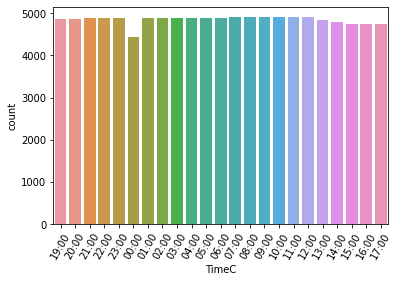

In [87]:
plt.figure()
sns.countplot(x='TimeC', data=df)
plt.xticks(rotation=60)

# 検証1
60分足データを使い、全期間にわたって1時間ごとの値動き（終値 - 始値）のデータを作成。この分布を可視化し、時間ごとの値動き傾向を調べる。

1. 日中取引が始まる直前は上昇する傾向が強い。
1. 夜間取引よりも日中取引の時間帯のほうが価格が大きく動く。
1. 日中取引よりも夜間取引のほうが上昇する傾向が強い。

## 結果
- 仮説1は「時間ごとの上昇確率プロット」より**支持されなかった**。日中取引は9:30から始まるが8時や9時の上昇確率が他の時間帯より高いという傾向は見られなかった。
- 仮説2は「時間ごとの値動き率の分散」より**支持された**。夜間の19:00-09:00よりも日中の10:00-16:00のほうが分散が大きいことから日毎の値動き率の変動が大きいことがわかる。
    - 分散は16:00で最大で、17:00は夜間の時間帯と同じくらい分散が小さい。これは取引終了間際は手仕舞いが多く仕掛ける人が少ないからかもしれない。
- 仮説3は「時間ごとの上昇確率プロット」より**支持されなかった。逆に夜間より日中のほうが上昇確率が高かった**。19:00-01:00は上昇確率が一番低い時間帯、03:00-09:00は上昇確率が中くらい、10:00-17:00にかけて上昇確率が最も高い時間帯ということが分かった。つまり、時間帯だけで見ると、01:00か09:00あたりで買いで仕掛けて、日中取引が終わる直前に手仕舞うというのが一番良いのかもしれない。売りなら日中取引終了直前または夜間取引開始直後に仕掛けて01:00付近または09:00付近で買い戻すというのが良いだろう。
    - これは、時間帯ごとの各価格の分布を調べることで検証できる。もし01:00や09:00より16:00や17:00の価格が高い傾向があるならこの仮説は支持される。

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]),
 <a list of 23 Text major ticklabel objects>)

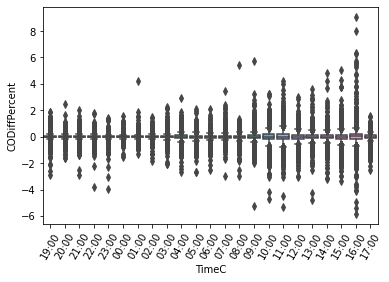

In [88]:
# 時間ごとの値動き率分布（ボックスプロット）
plt.figure()
sns.boxplot(x='TimeC', y='CODiffPercent', data=df)
plt.xticks(rotation=60)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]),
 <a list of 23 Text major ticklabel objects>)

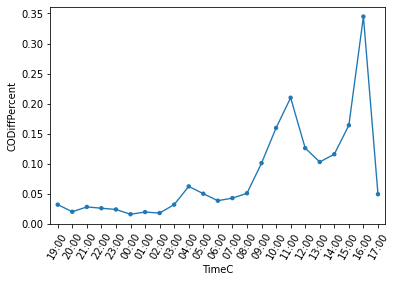

In [104]:
# 時間ごとの値動き率の分散
codiffP_var = df.groupby('TimeC')['CODiffPercent'].var()
plt.figure()
sns.pointplot(codiffP_var.index, codiffP_var, scale=0.5, linestyles='-')
plt.xticks(rotation=60)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]),
 <a list of 23 Text major ticklabel objects>)

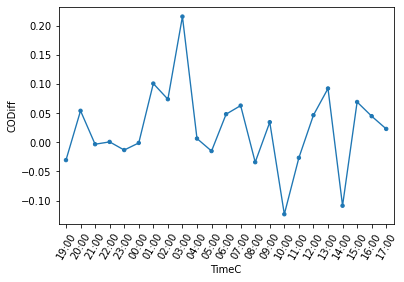

In [89]:
# 時間ごとの値動きの平均値
codiff_mean = df.groupby('TimeC')['CODiff'].mean()
plt.figure()
sns.pointplot(codiff_mean.index, codiff_mean, scale=0.5, linestyles='-')
plt.xticks(rotation=60)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]),
 <a list of 23 Text major ticklabel objects>)

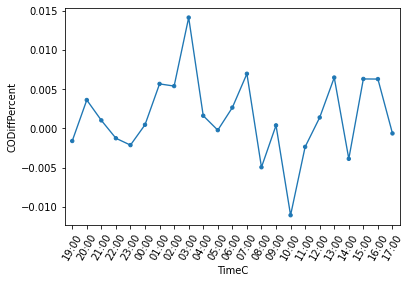

In [90]:
# 時間ごとの値動き率の平均値
codiffP_mean = df.groupby('TimeC')['CODiffPercent'].mean()
plt.figure()
sns.pointplot(codiffP_mean.index, codiffP_mean, scale=0.5, linestyles='-')
plt.xticks(rotation=60)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]),
 <a list of 23 Text major ticklabel objects>)

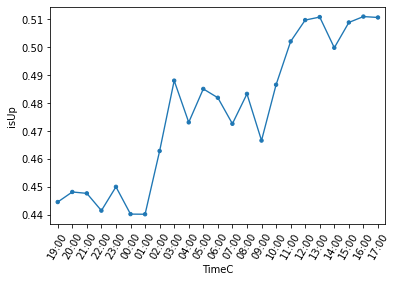

In [102]:
# 時間帯ごとの上昇確率（割合）
isUp_groups = df.groupby('TimeC')['isUp']
isUp_probs = isUp_groups.sum() / isUp_groups.count()
plt.figure()
sns.pointplot(isUp_probs.index, isUp_probs, scale=0.5, linestyles='-')
plt.xticks(rotation=60)